In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import utils

In [2]:
learning_rate_anr_capex = 0
learning_rate_h2_capex = 0
results_path = './results/raw_results_anr_lr_'+str(learning_rate_anr_capex)+'_h2_lr_'+str(learning_rate_h2_capex)+'_wacc_'+str(utils.WACC)+'.xlsx'
clean_save_path = './results/clean_results_anr_lr_'+str(learning_rate_anr_capex)+'_h2_lr_'+str(learning_rate_h2_capex)+'_wacc_'+str(utils.WACC)+'.xlsx'
save_fig_path = './results/refining_anr_lr_'+str(learning_rate_anr_capex)+'_h2_lr_'+str(learning_rate_h2_capex)+'_wacc_'+str(utils.WACC)+'.png'

In [3]:
df = pd.read_excel(results_path, sheet_name='refining')
df.sort_values(by=['Breakeven price ($/MMBtu)'], inplace=True)
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)

In [4]:
anr_param = pd.read_excel('ANRs.xlsx', sheet_name='FOAK')

### Compute deployed power at each refinery and cumulative deployed ANR capacity

In [5]:
anr_thermal_power = anr_param[['Power in MWt', 'Reactor']]
anr_thermal_power
df = df.merge(anr_thermal_power, how='inner', left_on=['ANR type'], right_on=['Reactor'])
df.sort_values(by=['Breakeven price ($/MMBtu)'], inplace=True)
df['Deployed Power (MWt)'] = df['Power in MWt']*df['# ANR modules']
df['ANR Nameplate Capacity (GWt)'] = df['Deployed Power (MWt)'].cumsum()/1000
df['Cum h2 dem (t/day)'] = df['H2 Dem. (kg/day)'].cumsum()/1000
df['Cum h2 dem (%)'] = df['H2 Dem. (kg/day)'].cumsum()/df['H2 Dem. (kg/day)'].sum()
df

,id,state,H2 Dem. (kg/day),Net Revenues ($/year),HTSE,Alkaline,PEM,Ann. CO2 emissions (kgCO2eq/year),ANR CAPEX ($/year),H2 CAPEX ($/year),...,Depl. ANR Cap. (MWe),ANR type,# ANR modules,Breakeven price ($/MMBtu),Power in MWt,Reactor,Deployed Power (MWt),ANR Nameplate Capacity (GWt),Cum h2 dem (t/day),Cum h2 dem (%)
0,CH_PAS,MS,296403.233462,-1.416767e+08,297,0,0,2.785506e+07,6.291660e+07,1.194230e+07,...,282.0,iMSR,2,8.656958,300,iMSR,600,0.60,296.403233,0.096141
1,Fl_SAI,MN,288453.321893,-1.409661e+08,289,0,0,2.710475e+07,6.291660e+07,1.162062e+07,...,282.0,iMSR,2,8.850930,300,iMSR,600,1.20,584.856555,0.189702
7,WR_WOO,IL,275407.694269,-1.347650e+08,276,0,0,2.495128e+07,5.980246e+07,1.069737e+07,...,240.0,PBR-HTGR,3,8.862385,200,PBR-HTGR,600,1.80,860.264250,0.279033
8,VA_BEN,CA,89510.008206,-4.475041e+07,90,0,0,8.136288e+06,1.993415e+07,3.488271e+06,...,80.0,PBR-HTGR,1,9.054722,200,PBR-HTGR,200,2.00,949.774258,0.308066
2,VA_NOR,LA,129433.726403,-6.919508e+07,130,0,0,1.219245e+07,3.145830e+07,5.227269e+06,...,141.0,iMSR,1,9.682276,300,iMSR,300,2.30,1079.207984,0.350049
9,HO_EL,KS,81172.794100,-4.406545e+07,82,0,0,7.413062e+06,1.993415e+07,3.178203e+06,...,80.0,PBR-HTGR,1,9.831898,200,PBR-HTGR,200,2.50,1160.380778,0.376378
10,TE_CAR,CA,79564.451739,-4.389421e+07,80,0,0,7.232256e+06,1.993415e+07,3.100686e+06,...,80.0,PBR-HTGR,1,9.991664,200,PBR-HTGR,200,2.70,1239.945230,0.402185
3,BP_FER,WA,123324.900195,-6.866212e+07,124,0,0,1.162972e+07,3.145830e+07,4.986011e+06,...,141.0,iMSR,1,10.083612,300,iMSR,300,3.00,1363.270130,0.442187
4,MA_MAR,CA,118683.640511,-6.821799e+07,119,0,0,1.116078e+07,3.145830e+07,4.784962e+06,...,141.0,iMSR,1,10.410168,300,iMSR,300,3.30,1481.953771,0.480682
5,WR_BOR,TX,117784.691027,-6.812916e+07,118,0,0,1.106699e+07,3.145830e+07,4.744752e+06,...,141.0,iMSR,1,10.475961,300,iMSR,300,3.60,1599.738462,0.518887


### Compute cumulative number of viable refineries and ANR modules

In [6]:
df['Viable ANR modules count'] = df['# ANR modules'].cumsum()
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)
df['Viable ANR refineries count'] = df.index+1
df.head(5)

,id,state,H2 Dem. (kg/day),Net Revenues ($/year),HTSE,Alkaline,PEM,Ann. CO2 emissions (kgCO2eq/year),ANR CAPEX ($/year),H2 CAPEX ($/year),...,# ANR modules,Breakeven price ($/MMBtu),Power in MWt,Reactor,Deployed Power (MWt),ANR Nameplate Capacity (GWt),Cum h2 dem (t/day),Cum h2 dem (%),Viable ANR modules count,Viable ANR refineries count
0,CH_PAS,MS,296403.233462,-1.416767e+08,297,0,0,2.785506e+07,6.291660e+07,1.194230e+07,...,2,8.656958,300,iMSR,600,0.6,296.403233,0.096141,2,1
1,Fl_SAI,MN,288453.321893,-1.409661e+08,289,0,0,2.710475e+07,6.291660e+07,1.162062e+07,...,2,8.850930,300,iMSR,600,1.2,584.856555,0.189702,4,2
2,WR_WOO,IL,275407.694269,-1.347650e+08,276,0,0,2.495128e+07,5.980246e+07,1.069737e+07,...,3,8.862385,200,PBR-HTGR,600,1.8,860.264250,0.279033,7,3
3,VA_BEN,CA,89510.008206,-4.475041e+07,90,0,0,8.136288e+06,1.993415e+07,3.488271e+06,...,1,9.054722,200,PBR-HTGR,200,2.0,949.774258,0.308066,8,4
4,VA_NOR,LA,129433.726403,-6.919508e+07,130,0,0,1.219245e+07,3.145830e+07,5.227269e+06,...,1,9.682276,300,iMSR,300,2.3,1079.207984,0.350049,9,5


### Compute avoided carbon emissions 

In [7]:
SMR_carbon_intensity = 11.888 #kgCO2eq/kgH2
df['Ann. avoided CO2 emissions (MMT-CO2/year)'] = (df['H2 Dem. (kg/day)']*365*SMR_carbon_intensity - df['Ann. CO2 emissions (kgCO2eq/year)'])/1e9
df['Viable avoided emissions (MMT-CO2/year)'] = df['Ann. avoided CO2 emissions (MMT-CO2/year)'].cumsum()
df[['Breakeven price ($/MMBtu)', 'Viable avoided emissions (MMT-CO2/year)']].tail(110)


,Breakeven price ($/MMBtu),Viable avoided emissions (MMT-CO2/year)
0,8.656958,1.258274
1,8.850930,2.482803
2,8.862385,3.652879
3,9.054722,4.033137
4,9.682276,4.582573
5,9.831898,4.927379
6,9.991664,5.265386
7,10.083612,5.788878
8,10.410168,6.292700
9,10.475961,6.792715


### Save clean version of results


In [8]:
df_clean = df[["id", 'state', 'H2 Dem. (kg/day)', 'HTSE', 'ANR type', '# ANR modules', 'Net Revenues ($/year)', 'Ann. avoided CO2 emissions (MMT-CO2/year)', 'Breakeven price ($/MMBtu)', 'Viable avoided emissions (MMT-CO2/year)']]

df_clean['H2 Dem. (kg/day)'] /=1e3
df_clean['HTSE'] = df_clean['HTSE'].apply(lambda x: int(x))
df_clean['H2 Dem. (kg/day)'] = df_clean['H2 Dem. (kg/day)'].apply(lambda x:np.round(x,1))
df_clean['Net Revenues ($/year)'] /=1e6
df_clean['Avoided cost of CO2 ($/ton)'] = df_clean['Net Revenues ($/year)']/df_clean['Ann. avoided CO2 emissions (MMT-CO2/year)']
df_clean['Avoided cost of CO2 ($/ton)'] = df_clean['Avoided cost of CO2 ($/ton)'].apply(lambda x:np.round(np.abs(x),1))
df_clean['Net Revenues ($/year)'] = df_clean['Net Revenues ($/year)'].apply(lambda x: np.abs(np.round(x,1)))
df_clean['Ann. avoided CO2 emissions (MMT-CO2/year)']= df_clean['Ann. avoided CO2 emissions (MMT-CO2/year)'].apply(lambda x: np.round(x,1))
df_clean['Breakeven price ($/MMBtu)'] = df_clean.apply(lambda x:np.round(x['Breakeven price ($/MMBtu)'],1), axis=1)
df_clean.rename(columns={'RH2 Dem. (kg/day)': 'Demand (MT H2/day)',
                         'ANR type': 'ANR', 
                         '# ANR modules': '#'}, inplace=True)
df_clean.sort_values(by=['Breakeven price ($/MMBtu)'], inplace=True)


C:\Users\mgarrou\AppData\Local\Temp\ipykernel_17952\2103974781.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['H2 Dem. (kg/day)'] /=1e3
C:\Users\mgarrou\AppData\Local\Temp\ipykernel_17952\2103974781.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['HTSE'] = df_clean['HTSE'].apply(lambda x: int(x))
C:\Users\mgarrou\AppData\Local\Temp\ipykernel_17952\2103974781.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [9]:
sheet_name = 'refining'
excel_file = clean_save_path
try:
# Load the existing Excel file
  with pd.ExcelFile(excel_file, engine='openpyxl') as xls:
      # Check if the sheet exists
      if sheet_name in xls.sheet_names:
          # If the sheet exists, replace the data
          with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
              df.to_excel(writer, sheet_name=sheet_name, index=False)
      else:
          # If the sheet doesn't exist, create a new sheet
          with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a') as writer:
              df.to_excel(writer, sheet_name=sheet_name, index=False)
except FileNotFoundError:
    # If the file doesn't exist, create a new one and write the DataFrame to it
    df.to_excel(excel_file, sheet_name=sheet_name, index=False)

### Plots

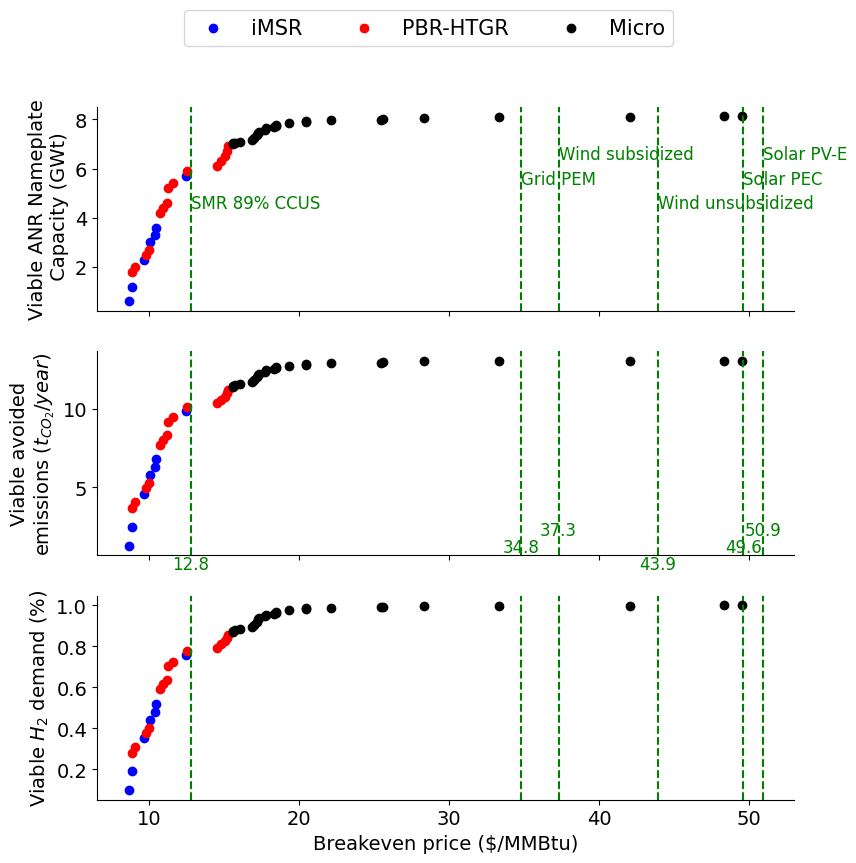

In [10]:
#Use latex font
#plt.rcParams['text.usetex'] = True
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['font.size'] = 14

# Create subplots
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(9, 9))

# Get unique ANR types and assign colors
anr_types = df['ANR type'].unique()

colors = ['blue', 'red', 'black']  # Adjust the colors according to the unique ANR types
# Initialize empty handles for legend
handles = []
# Plotting the data as scatter plots with different colors for each ANR type
labels = {'ANR Nameplate Capacity (GWt)': 'Viable ANR Nameplate\n Capacity (GWt)',
            'Viable avoided emissions (MMT-CO2/year)': 'Viable avoided\n'r'emissions ($t_{CO_2}/year$)',
            'Cum h2 dem (%)':r'Viable $H_2$ demand (%)'}
for i, col in enumerate(['ANR Nameplate Capacity (GWt)', 'Viable avoided emissions (MMT-CO2/year)', 'Cum h2 dem (%)']):
    for anr_type, color in zip(anr_types, colors):
        subset = df[df['ANR type'] == anr_type]
        axs[i].scatter(subset['Breakeven price ($/MMBtu)'], subset[col], color=color, label=f'{anr_type}')
    axs[i].set_ylabel(labels[col])

    # Remove the top and right spines
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)

    # Adding vertical lines
    res_be = pd.read_csv('./results/res_be_refining.csv')
    res_be.sort_values(by='Breakeven price ($/MMBtu)', inplace=True)
    res_be['Breakeven price ($/MMBtu)'] = res_be.apply(lambda x:np.round(x['Breakeven price ($/MMBtu)'],1), axis=1)
    ng_vertical_lines = [6.4, 13, 40]
    ng_labels = ['US NG\navg 2022', 'CA NG\ndelivered 2022', 'EU NG\n 2022']
    res_vert_lines = list(res_be['Breakeven price ($/MMBtu)'])
    #for line in ng_vertical_lines:
     #   axs[i].axvline(x=line, linestyle='--', color='grey')
    for l,line in enumerate(res_vert_lines):
        axs[i].axvline(x=line, linestyle='--',color='green')


"""ng_labels = ['US NG\navg 2022', 'CA NG\ndelivered 2022', 'EU NG\n 2022']
for x, l in zip(ng_vertical_lines, ng_labels):
    axs[0].text(x-2, axs[0].get_ylim()[1]+0.2, l, fontsize=12, color='grey')
    axs[1].text(x, axs[i].get_ylim()[0]-0.5, str(x), color='grey', fontsize=12, va='top', ha='center')
"""
res_labels = res_be['RES']
count = 0
for x, label in zip(res_vert_lines, res_labels):
    axs[0].text(x, (axs[0].get_ylim()[1]+axs[0].get_ylim()[0])/2+np.mod(count,3), label, fontsize=12, color='green')
    axs[1].text(x, axs[1].get_ylim()[0]+1.1*np.mod(count,3), str(x), color='green', fontsize=12, va='top',ha='center')
    count+=1

# Setting the title and labels
plt.xlabel('Breakeven price ($/MMBtu)')
#fig.text(0.5, 0.07, 'Breakeven price ($/MMBtu)', ha='center')

# Add a common legend for all subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(anr_types))
#fig.tight_layout()
#plt.show()
plt.savefig(save_fig_path)